<a href="https://colab.research.google.com/github/dinuwanfernando/BTCUSD_model/blob/main/BTCUSD_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import tensorflow as tf
#from tensorflow.keras import layers

In [2]:
#print('Num GPUs Available:', len(tf.config.experimental.list_physical_devices('GPU')))

In [3]:
#!nvidia-smi

In [4]:
#!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from math import sqrt
import matplotlib.pyplot as plt
!pip install prophet
from prophet import Prophet

In [7]:
%pip install oandapyV20
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
from oandapyV20.contrib.requests import MarketOrderRequest
access_token = "25828916746768cb5cf6f0ec2b97218e-0b9185adf70ecd8cf1b53bb781a4b1f3"
%pip install git+https://github.com/yhilpisch/tpqoa.git
api = oandapyV20.API(access_token=access_token)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=69779 sha256=811e9767ae38788b98b35a7a74d9b5fbc9bfda02deb477d43c6e442087071b1d
  Stored in directory: /root/.cache/pip/wheels/8e/69/ab/a6da84a85b9bf3b5a98ca15c6c52b7854f32b10c70fe0531a1
Successfully built oandapyV20
  Cloning https://github.com/yhilpisch/tpqoa.git to /tmp/pip-req-build-9c9d21sg
  Running command git clone --filter=blob:none --quiet https://github.com/yhilpisch/tpqoa.git /tmp/pip-req-build-9c9d21sg
  Resolved https://github.com/yhilpisch/tpqoa.git to commit 4a79f30b7095642844ef99741d9bfcb952e394db
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 5.8 MB/s eta 0:00:00
  Created wheel for tpqoa: filename=tpq

In [8]:
import tpqoa
oanda = tpqoa.tpqoa("/content/drive/MyDrive/ML BTCUSD model/oanda.cfg.txt")

In [9]:
date_var= '2024-04-01'

In [10]:
df_BTC_pp_01= oanda.get_history(instrument= 'BTC_USD', start= '2014-05-07', end='2016-05-06', granularity= 'H1', price='M')
df_BTC_pp_02= oanda.get_history(instrument= 'BTC_USD', start= '2016-05-07', end='2018-05-06', granularity= 'H1', price='M')
df_BTC_pp_03= oanda.get_history(instrument= 'BTC_USD', start= '2018-05-07', end='2020-05-06', granularity= 'H1', price='M')
df_BTC_pp_04= oanda.get_history(instrument= 'BTC_USD', start= '2020-05-07', end='2022-05-06', granularity= 'H1', price='M')
df_BTC_pp_05= oanda.get_history(instrument= 'BTC_USD', start= '2022-05-07', end='2023-05-06', granularity= 'H1', price='M')
df_BTC_pp_06= oanda.get_history(instrument= 'BTC_USD', start= '2023-05-07', end='2024-01-06', granularity= 'H1', price='M')
df_BTC_pp_07= oanda.get_history(instrument= 'BTC_USD', start= '2024-01-07', end=date_var, granularity= 'H1', price='M')

In [11]:
df_btc_p= pd.concat([df_BTC_pp_01,df_BTC_pp_02,df_BTC_pp_03,df_BTC_pp_04,df_BTC_pp_05,df_BTC_pp_06,
df_BTC_pp_07],axis=0).dropna()
df_btc_p.index= pd.to_datetime(df_btc_p.index)
df_btc_p= df_btc_p[df_btc_p.index < date_var].dropna()
#df_btc_dat.index= df_btc_data.index.date to add the time back
df_btc_p = df_btc_p.rename_axis('Date')
df_btc_p.rename(columns={'o': 'open', 'h': 'high', 'l': 'low', 'c': 'btc_close','volume':'btc_volume'}, inplace=True)
df_btc_p= df_btc_p[['high','low','btc_close','btc_volume']]
df_btc_p1=df_btc_p.astype(float)
print(df_btc_p1)
df_btc_p1.dtypes

                        high      low  btc_close  btc_volume
Date                                                        
2016-01-01 06:00:00    437.0    433.0      435.5      1616.0
2016-01-01 07:00:00    437.2    434.9      435.3      1620.0
2016-01-01 08:00:00    436.8    433.3      435.5      1377.0
2016-01-01 09:00:00    435.9    434.1      434.5       868.0
2016-01-01 10:00:00    435.9    433.4      433.9       789.0
...                      ...      ...        ...         ...
2024-03-29 19:00:00  69709.4  69400.0    69704.4     12317.0
2024-03-29 20:00:00  69757.8  69560.4    69640.6      9426.0
2024-03-31 21:00:00  70970.8  70645.2    70881.8      6836.0
2024-03-31 22:00:00  71120.0  70870.0    70983.4      8352.0
2024-03-31 23:00:00  71424.0  70944.8    71321.4     12109.0

[54869 rows x 4 columns]


high          float64
low           float64
btc_close     float64
btc_volume    float64
dtype: object

In [12]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

# Define features and target variable
features = ['high', 'low', 'btc_volume']
target = 'btc_close'

X_train, X_test, y_train, y_test = train_test_split(df_btc_p1[features], df_btc_p1[target], test_size=0.2, random_state=42)


In [13]:
# Machine learning model
from xgboost import XGBRegressor

model = XGBRegressor()


In [14]:
# Train the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
# Make predictions on the test set
y_pred = model.predict(X_test)


In [16]:
# Evaluate the model (optional)
from sklearn.metrics import mean_squared_error

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 32746.879768877727


In [17]:
# Predict for the next 5 days
future_dates = pd.date_range(start=date_var, periods=5, freq='D')
future_df = pd.DataFrame({'Date': future_dates})

In [18]:
print(future_df)

        Date
0 2024-04-01
1 2024-04-02
2 2024-04-03
3 2024-04-04
4 2024-04-05


In [19]:
# Ensure features are present in future_df
#for feature in features:  # features = ['high', 'low', 'btc_volume']
  #if feature not in future_df.columns:
   # future_df[feature] = np.NAN  # Fill with NaN or most recent value

In [20]:
# Use the trained model to predict prices for the next 5 days
#future_df['Predicted_Price'] = model.predict(future_df[features])

# Print the predicted prices
#print(future_df)

In [21]:
# Ensure features are present in future_df
for feature in features:
 if feature not in future_df.columns:
    future_df[feature] = df_btc_p1[feature].tail(1).values[0]  # Fill with most recent value

In [22]:
# Use the trained model to predict prices
future_df['Predicted_Price'] = model.predict(future_df[features])

# Print the DataFrame with filled values
print(future_df)

        Date     high      low  btc_volume  Predicted_Price
0 2024-04-01  71424.0  70944.8     12109.0     71163.953125
1 2024-04-02  71424.0  70944.8     12109.0     71163.953125
2 2024-04-03  71424.0  70944.8     12109.0     71163.953125
3 2024-04-04  71424.0  70944.8     12109.0     71163.953125
4 2024-04-05  71424.0  70944.8     12109.0     71163.953125


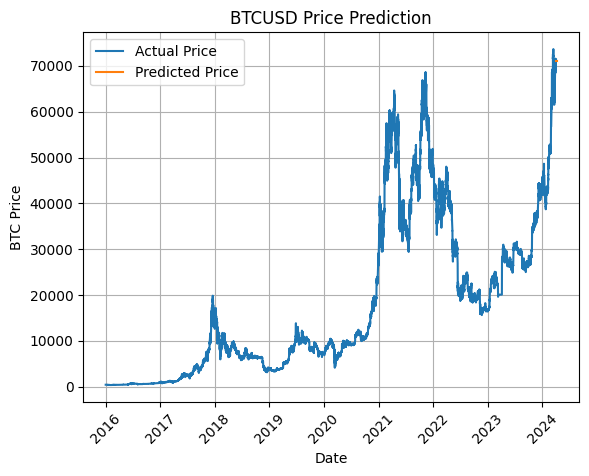

In [23]:
# Plot actual historical prices
plt.plot(df_btc_p1.index, df_btc_p1['btc_close'], label='Actual Price')

# Plot predicted prices (assuming 'future_df' has predicted prices)
plt.plot(future_df['Date'], future_df['Predicted_Price'], label='Predicted Price')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.title('BTCUSD Price Prediction')

# Add legend and grid
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)  # Uncomment this line if needed

# Show the plot
plt.show()